In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

## Telco customer churn 

https://www.kaggle.com/datasets/blastchar/telco-customer-churn

- **customerID**: Customer ID
- **gender**: Whether the customer is a male or a femal
- **SeniorCitizen**: Whether the customer is a senior citizen or not (1, 0)
- **Partner**: Whether the customer has a partner or not (Yes, No)
- **Dependents**: Whether the customer has dependents or not (Yes, No)
- **tenure**: Number of months the customer has stayed with the company
- **PhoneService**: Whether the customer has a phone service or not (Yes, No)
- **MultipleLines**: Whether the customer has multiple lines or not (Yes, No, No phone service)
- **InternetService**: Customer’s internet service provider (DSL, Fiber optic, No)
- **OnlineSecurity**: Whether the customer has online security or not (Yes, No, No internet service)
- **OnlineBackup**: Whether the customer has online backup or not (Yes, No, No internet service)
- **DeviceProtection**: Whether the customer has device protection or not (Yes, No, No internet service)
- **TechSupport**: Whether the customer has tech support or not (Yes, No, No internet service)
- **StreamingTV**: Whether the customer has streaming TV or not (Yes, No, No internet service)
- **StreamingMovies**: Whether the customer has streaming movies or not (Yes, No, No internet service)
- **Contract**: The contract term of the customer (Month-to-month, One year, Two year)
- **PaperlessBilling**: Whether the customer has paperless billing or not (Yes, No)
- **PaymentMethod**: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- **MonthlyCharges**: The amount charged to the customer monthly
- **TotalCharges**: The total amount charged to the customer
- **Churn**: Whether the customer churned or not (Yes or No)

In [221]:
path_data = r"C:\Users\LaurèneDAVID\Documents\Teaching\Educational_apps\app-hec-AI-DS\data\classification\telco-customer-churn.csv"
churn_data = pd.read_csv(path_data)

In [222]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [223]:
churn_data.drop(columns=["gender","customerID"],inplace=True)

In [224]:
churn_data["MultipleLines"] = churn_data["MultipleLines"].apply(lambda x: 0 if x in ["No","No phone service"] else 1)

In [225]:
for col in ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]:
    churn_data[col] = churn_data[col].apply(lambda x: 0 if x in ["No internet service", "No"] else 1)

In [226]:
binary_columns = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
for col in binary_columns:
    churn_data[col] = churn_data[col].map({"No":0, "Yes":1})

In [227]:
churn_data["TotalCharges"] = churn_data["TotalCharges"].apply(lambda x: np.nan if x==' ' else x).astype(float)

<Axes: xlabel='TotalCharges', ylabel='Density'>

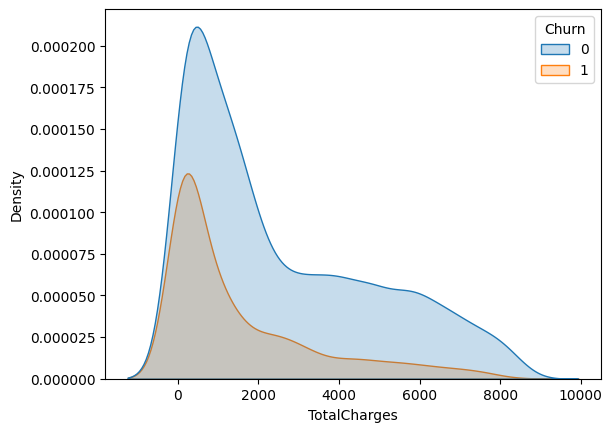

In [228]:
sns.kdeplot(data=churn_data, x="TotalCharges", hue="Churn", fill="Churn")

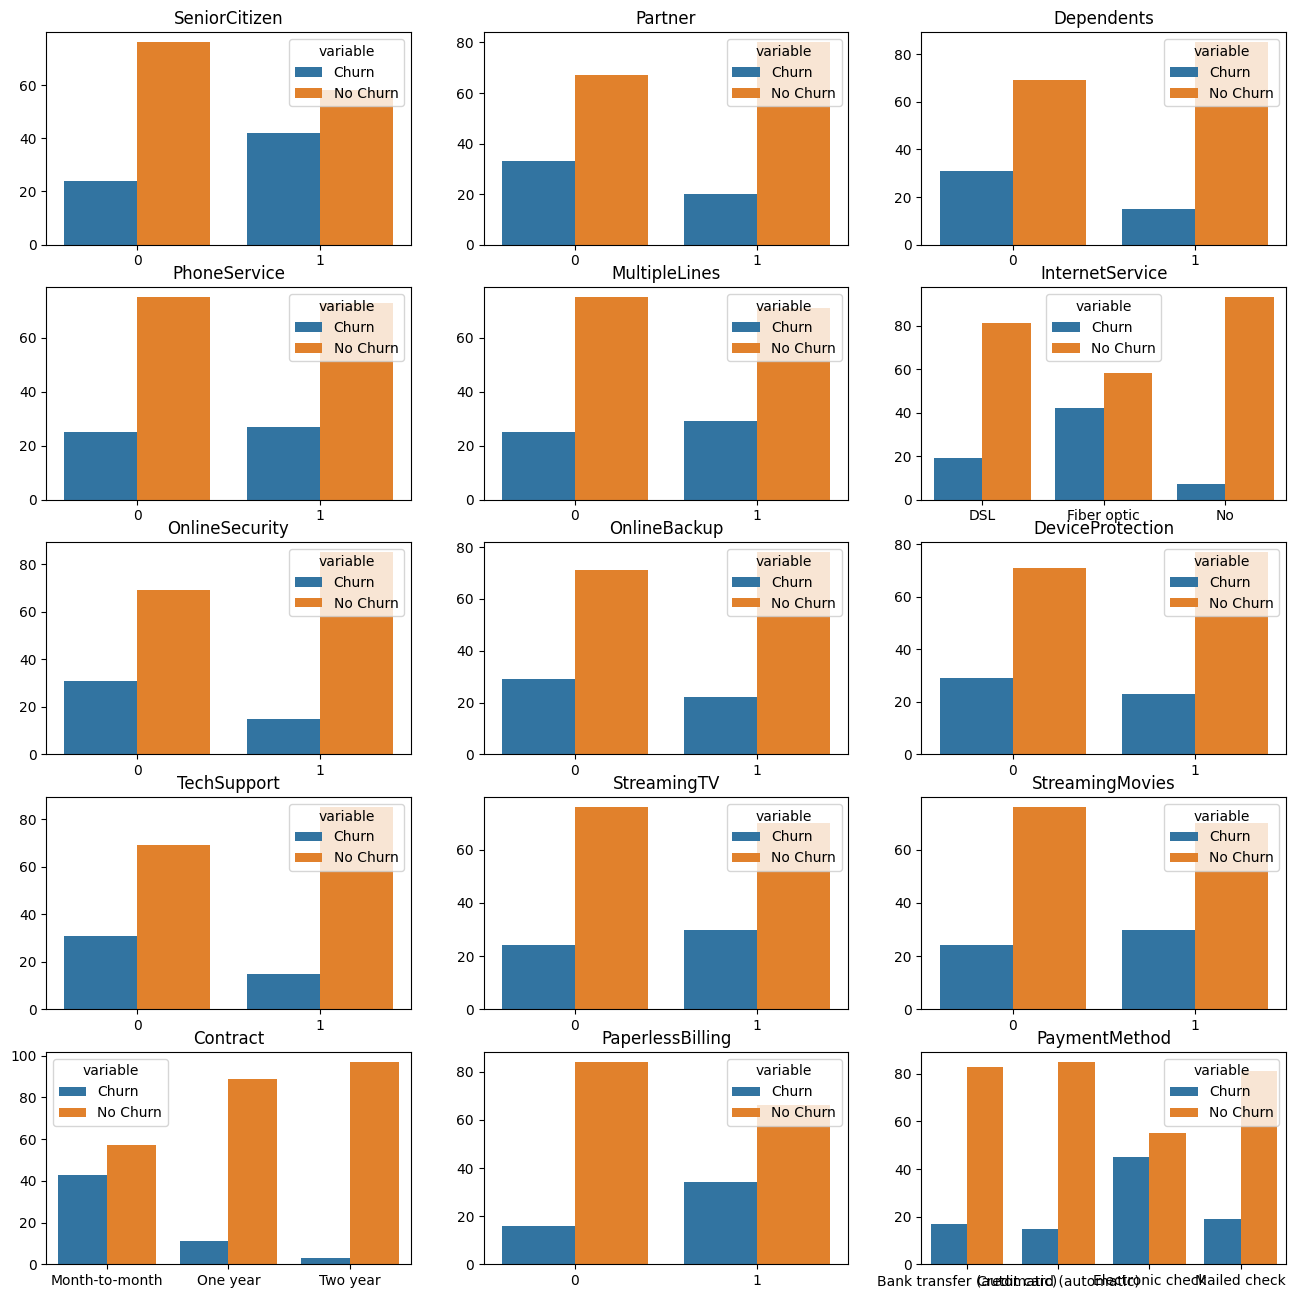

In [229]:
# Exploratory Data Analysis on categorical variables

cat_columns_plot = [col for col in churn_data.select_dtypes(include=["object","int"]).columns if col not in ["Churn","tenure"]]

plt.figure(figsize=(16,16))
for i,col in enumerate(cat_columns_plot):
    plt.subplot(5,3,i+1)

    df_plot = pd.crosstab(churn_data[col], churn_data["Churn"].map({0:"No Churn", 1:"Churn"}), normalize="index").apply(lambda x: np.round(100*x)).reset_index(drop=False)
    df_plot.rename_axis(None, axis=1, inplace=True)
    df_plot = df_plot.melt(id_vars=[col])

    sns.barplot(data = df_plot, x=col, y="value", hue="variable")
    plt.xlabel("")
    plt.ylabel("")
    plt.title(str(col))

In [201]:
from sklearn.model_selection import train_test_split

X = churn_data.drop(columns=["Churn"])
y = churn_data["Churn"]

# Split train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [202]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

num_columns = list(churn_data.select_dtypes(include=["float"]).columns)
num_columns.append("tenure")

cat_columns = churn_data.select_dtypes(include=["object"]).columns

# Build data processing pipeline
ct = ColumnTransformer(
    [("numerical", MinMaxScaler(), num_columns), 
     ("categorical", OneHotEncoder(sparse_output=False), cat_columns)], 
      remainder='passthrough')

X_train_pp = ct.fit_transform(X_train)
X_test_pp = ct.transform(X_test)

In [203]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

rf = RandomForestClassifier(max_depth=12, class_weight="balanced_subsample")
rf.fit(X_train_pp, y_train)

y_pred_train = rf.predict(X_train_pp)
y_pred_test = rf.predict(X_test_pp)

print("Train Accuracy", accuracy_score(y_train, y_pred_train))
print("Test Accuracy", accuracy_score(y_test, y_pred_test))

Train Accuracy 0.8759318423855165
Test Accuracy 0.7757274662881476


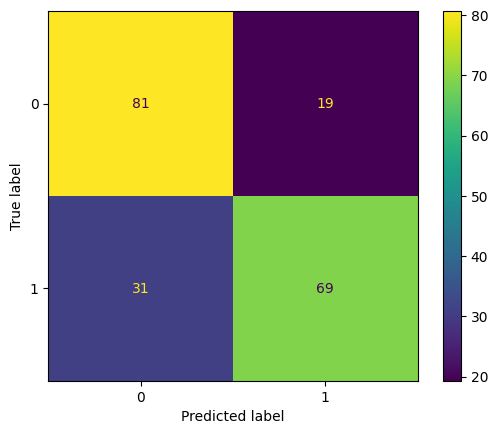

In [204]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_test, normalize="true")*100
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

In [205]:
rf.feature_importances_

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

### LightGBM

In [206]:
import lightgbm as lgb

params = {
'boosting_type': 'gbdt',
'num_leaves': 30,
'learning_rate': 0.05,
'feature_fraction': 0.9
}

clf = lgb.LGBMClassifier(**params)
clf.fit(X_train_pp, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328


LGBMClassifier(feature_fraction=0.9, learning_rate=0.05, num_leaves=30)

In [207]:
y_pred_lgb_train = clf.predict(X_train_pp)
y_pred_lgb_test = clf.predict(X_test_pp)

print("Train Accuracy", accuracy_score(y_train, y_pred_lgb_train))
print("Test Accuracy", accuracy_score(y_test, y_pred_lgb_test))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Train Accuracy 0.8473553425630103
Test Accuracy 0.7913413768630234


<Axes: xlabel='importance', ylabel='variable'>

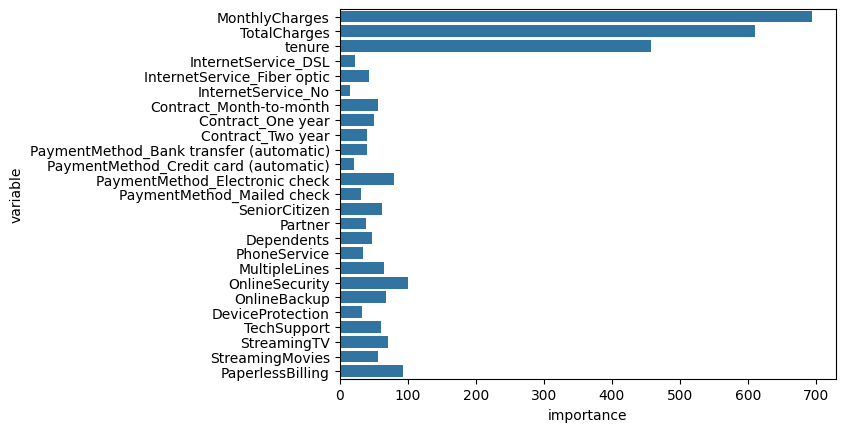

In [208]:
columns_transform = [col.split("__")[1] for col in ct.get_feature_names_out()]

df_features_imp = pd.DataFrame({"variable":columns_transform,
                               "importance":clf.feature_importances_})

sns.barplot(data=df_features_imp, x="importance", y="variable")

### CatBoost

In [81]:
from sklearn.model_selection import train_test_split

X = churn_data.drop(columns=["Churn"])
y = churn_data["Churn"]

# Split train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Split train/validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

In [85]:
from catboost import CatBoostClassifier

cat_features = [col for col in X_train.select_dtypes(include=["object","int"]) if col != "tenure"]

clf = CatBoostClassifier()


clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_val, y_val), 
        verbose=True
)

print('CatBoost model parameters:')
print(clf.get_params())

Learning rate set to 0.048569
0:	learn: 0.6627881	test: 0.6623821	best: 0.6623821 (0)	total: 32.5ms	remaining: 32.5s
1:	learn: 0.6372805	test: 0.6359148	best: 0.6359148 (1)	total: 62.2ms	remaining: 31.1s
2:	learn: 0.6118743	test: 0.6094715	best: 0.6094715 (2)	total: 97.7ms	remaining: 32.5s
3:	learn: 0.5898587	test: 0.5870121	best: 0.5870121 (3)	total: 123ms	remaining: 30.6s
4:	learn: 0.5729321	test: 0.5694306	best: 0.5694306 (4)	total: 141ms	remaining: 28.1s
5:	learn: 0.5563865	test: 0.5527201	best: 0.5527201 (5)	total: 166ms	remaining: 27.5s
6:	learn: 0.5406930	test: 0.5370096	best: 0.5370096 (6)	total: 194ms	remaining: 27.5s
7:	learn: 0.5268732	test: 0.5229710	best: 0.5229710 (7)	total: 223ms	remaining: 27.7s
8:	learn: 0.5149236	test: 0.5106099	best: 0.5106099 (8)	total: 255ms	remaining: 28.1s
9:	learn: 0.5067475	test: 0.5020982	best: 0.5020982 (9)	total: 271ms	remaining: 26.9s
10:	learn: 0.4972163	test: 0.4926949	best: 0.4926949 (10)	total: 301ms	remaining: 27s
11:	learn: 0.4896058	